In [3]:
%load_ext autoreload
%autoreload 2
path_src = "../../src"
import sys
from pathlib import Path
import pandas as pd

sys.path.append(path_src)
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from metrics import remove_by_size, root, label_files, size_files, meta_files, visualize_iom, add_size_based_fields

from froc import FROCEvaluator
import os

df_labels_val_with_sizes = pd.read_csv(label_files["val"])
max_fppi = 10.0
min_fppi = 0.0
fp_scale = "linear"
fppi_thrs = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
n_bootstraps = 10000
total_volumes = {"val": 152, "ext": 138, "hospital": 38}
root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('../..')

In [4]:
from metrics_config import inf_appends, thresholds

iou_thr = 0.2
viz_mode = False
viz_mode_exp = "_PRIV"

dataset = "hospital"
exps = ["decoder_only_no_rec_input_edt"]


values = []

for exp in exps:
    # exp = exps[0]
    inf_append = inf_appends[exp]
    print("\n" + "---" * 10 + "\n")
    path_inf = "inference_" + inf_append
    print(f"Running iou_thr: {iou_thr} at {inf_append}")
    mode = "hospital"
    n_workers = 8
    path_preds = root / f"./results/{dataset}/{exp}/{path_inf}/predict.csv"
    if not os.path.isfile(path_preds):
        print(f"No data for checkpoint {inf_append}/partition {mode}")
        continue
    preds = pd.read_csv(path_preds)
    sizes = None
    label_file = label_files[mode]
    # if mode == "hospital":
    #     sizes = pd.read_json(size_files["hospital"])

    df_labels = pd.read_csv(label_file)
    df_labels = add_size_based_fields(df_labels)
    #
    # df_labels = df_labels.sample(frac=1, random_state=5).reset_index(drop=True)
    # df_labels_small = df_labels[df_labels["size"] == "small"].sample(n=7)
    # df_labels_large = df_labels[df_labels["size"] == "large"].sample(n=3)
    # df_labels_med = df_labels[df_labels["size"] == "medium"].sample(n=23)
    # df_labels = pd.concat([df_labels_small, df_labels_large, df_labels_med])
    # df_labels.to_csv("../../labels/gt/hospital_crop_0.4_subsample.csv")
    # # 28 + 9 + 3
    # break
    # df_labels[["intersection_art", "intersection_vein", "avg_distance_art"]] = (
    # if mode == "hospital":
    #     preds = remove_by_size(preds, sizes)
    vols = total_volumes[mode]
    evaluator = FROCEvaluator(
        label_file=label_file,
        preds=preds,
        logger=None,
        iou_thr=iou_thr,
        out_dir=root / f"outputs/{exp}/iou{iou_thr:.1f}_froc_{inf_append}",
        max_fppi=max_fppi,
        fppi_thrs=fppi_thrs,
        min_fppi=min_fppi,
        n_bootstraps=n_bootstraps,
        n_workers=n_workers,
        fp_scale=fp_scale,
        meta_data=None,
        use_world_xyz=False,
        exp_name=exp + "_" + inf_append,
        mode=mode,
    )
    evaluator.evaluate()
    total_correct = 0
    total_correct_any = 0
    total_fp = 0
    total_fn = 0

    correct_per_case = []
    fp_per_case = []
    fn_per_case = []
    gt_per_case = []
    correct_dets = []
    fp_list = []

    t = thresholds[exp]
    preds = preds[preds["probability"] > t]
    case_names = []

    for key in evaluator._match_results.keys():
        gt_per_case.append(len(df_labels[df_labels["seriesuid"] == key]))
        un_matched_gt = evaluator._match_results[key]["aneurysm"]["un_matched_gt"]
        all_un_matched_gt = evaluator._match_results[key]["aneurysm"][
            "all_un_matched_gt"
        ]
        filtered_umgt = [x for x in all_un_matched_gt if x[0] > t]
        un_matched_gt = (
            filtered_umgt[-1][-1] if len(filtered_umgt) > 0 else np.array([])
        )
        case_names.append(key)
        if len(un_matched_gt) > 1:
            un_matched_gt = un_matched_gt[0:-1]
            total_correct_any += np.sum(un_matched_gt == 0)
            correct_dets += list(un_matched_gt == 0)
            fn = np.sum(un_matched_gt)
        else:
            fn = len(df_labels[df_labels["seriesuid"] == key])
            correct_dets += [0] * len(df_labels[df_labels["seriesuid"] == key])
        fn_per_case.append(fn)
        scores = evaluator._match_results[key]["aneurysm"]["scores"].copy()
        gt = evaluator._match_results[key]["aneurysm"]["gts"].copy()
        gt[scores < t] = 0
        correct_per_case.append(np.sum(gt))
        fp_per_case.append(np.sum(gt[scores >= t] == 0))
        is_fp = list(gt[scores >= t] == 0)
        fp_list += is_fp
        # for res in evaluator._match_results[key]:

    total_fp = np.sum(fp_per_case)
    total_fn = np.sum(fn_per_case)
    total_correct = np.sum(correct_per_case)
    total_gt = np.sum(gt_per_case)
    df_labels["detected"] = np.array(correct_dets).astype(np.int8)

    df_labels["size"].value_counts()
    preds["is_fp"] = np.array(fp_list).astype(np.int8)
    healthy_case_indexes = np.where(np.array(gt_per_case) == 0)[0]
    healthy_fp = np.array(fp_per_case)[healthy_case_indexes]
    healthy_fp = healthy_fp[healthy_fp > 0]
    sick_case_indics = np.where(np.array(gt_per_case) > 0)[0]
    sick_fn = np.array(fn_per_case)[sick_case_indics]

    print("Total cases:", vols)

    print("Number of aneurysms:", total_gt)

    print("Healthy cases:", len(healthy_case_indexes))
    print("Confidence threshold:", t)
    print("Recall:", 100 * total_correct / total_gt)
    values.append(total_correct / total_gt)
    print("FP rate:", total_fp / vols)
    print("Total False Negatives:", f"{int(np.sum(fn_per_case))}/{total_gt}")
    print(
        "FP rate (Healthy patients):",
        (
            None
            if len(healthy_case_indexes) == 0
            else np.array(fp_per_case)[healthy_case_indexes].sum()
            / len(healthy_case_indexes)
        ),
    )
    print(
        "Patient-level specificity",
        f"{len(healthy_case_indexes) - len(healthy_fp)}/{len(healthy_case_indexes)}",
    )
    print(
        "Patient-level sensitivity",
        f"{len(sick_case_indics) - sum(sick_fn > 0)} / {len(sick_case_indics)}",
    )


------------------------------

Running iou_thr: 0.2 at 52k
../../outputs/decoder_only_no_rec_input_edt/iou0.2_froc_52k
Total cases: 38
Number of aneurysms: 58
Healthy cases: 0
Confidence threshold: 0.8
Recall: 82.75862068965517
FP rate: 7.631578947368421
Total False Negatives: 10/58
FP rate (Healthy patients): None
Patient-level specificity 0/0
Patient-level sensitivity 28 / 38


In [5]:
df_labels

,seriesuid,coordX,coordY,coordZ,w,h,d,lesion,volume,min_axis,maj_axis,iom_artery,iom_vein,distance_to_artery,volume_mm,diameter,size,partition,detected
0,CA_00001_0000.nii.gz,284.5,334.5,139.5,14,16,12,aneurysm,1360.0,13.303996,16.579593,0.778676,0.000000,5.656854,87.040,3.972628,medium,Hosp,1
1,CA_00000_0000.nii.gz,305.0,319.5,155.5,17,18,14,aneurysm,1630.0,12.982818,20.656223,0.631288,0.069939,2.236068,104.320,4.219822,medium,Hosp,0
2,CA_00000_0000.nii.gz,315.0,317.0,165.0,5,5,1,aneurysm,25.0,0.000000,6.324555,0.560000,0.000000,1.000000,1.600,1.048443,small,Hosp,1
3,CA_00006_0000.nii.gz,203.5,312.5,118.5,12,10,6,aneurysm,650.0,7.248211,14.520893,0.000000,0.856923,3.000000,41.600,3.106009,medium,Hosp,1
4,CA_00006_0000.nii.gz,228.0,291.5,133.0,7,6,3,aneurysm,114.0,3.475996,8.686794,0.622807,0.000000,2.236068,7.296,1.738601,small,Hosp,0
5,CA_00003_0000.nii.gz,247.5,320.0,148.0,16,15,17,aneurysm,2410.0,15.051012,19.557423,0.701245,0.000000,6.928203,154.240,4.807331,medium,Hosp,1
6,CA_00007_0000.nii.gz,301.0,313.0,152.0,7,7,3,aneurysm,126.0,3.598825,8.619500,0.904762,0.000000,2.236068,8.064,1.797581,small,Hosp,0
7,CA_00007_0000.nii.gz,335.5,327.5,189.0,12,10,9,aneurysm,656.0,7.956748,13.677878,0.606707,0.000000,3.316625,41.984,3.115537,medium,Hosp,1
8,CA_00002_0000.nii.gz,332.5,339.5,141.0,6,6,3,aneurysm,102.0,3.554910,7.637626,0.401961,0.000000,1.000000,6.528,1.675322,small,Hosp,1
9,CA_00002_0000.nii.gz,305.5,354.5,161.5,6,6,2,aneurysm,72.0,2.236068,7.637626,0.625000,0.000000,1.000000,4.608,1.491680,small,Hosp,0


In [7]:
dataset_1 = values[0]
cases_1 = 152
dataset_2 = values[1]
cases_2 = 138

perf = (dataset_1 * cases_1 + dataset_2 * cases_2) / (cases_1 + cases_2)
perf

IndexError: list index out of range

In [ ]:
thresholds = [0.1, 0.25, 0.75, 0.9]
recalls_int = [0.9444444444444444, ]
recalls_ext = [ 0.9702970297029703, ]

In [3]:
df_labels["size"].value_counts()

size
medium    73
large     14
small     14
Name: count, dtype: int64

In [32]:
40 * 0.71, 40 * 0.23, 40 * 0.06

(28.4, 9.200000000000001, 2.4)

40

In [29]:
medium = 0.71
small = 0.23
large = 0.06
# small =
29 / (90 + 29 + 7)

0.23015873015873015

In [24]:
df_labels["size"].value_counts()

size
medium    27
small     27
large      3
Name: count, dtype: int64

In [6]:
df_labels

,seriesuid,coordX,coordY,coordZ,w,h,d,lesion,volume,min_axis,maj_axis,iom_artery,iom_vein,volume_mm,diameter,size,partition,detected
0,CA_00000_0000.nii.gz,305.0,319.5,169.5,17,18,14,aneurysm,1630.0,12.982818,20.656223,0.636810,0.065031,104.320,4.219822,medium,Hosp,0
1,CA_00000_0000.nii.gz,315.0,317.0,179.0,5,5,1,aneurysm,25.0,0.000000,6.324555,0.600000,0.000000,1.600,1.048443,small,Hosp,0
2,CA_00001_0000.nii.gz,284.5,334.5,145.5,14,16,12,aneurysm,1360.0,13.303996,16.579593,0.784559,0.000000,87.040,3.972628,medium,Hosp,0
3,CA_00002_0000.nii.gz,332.5,339.5,141.0,6,6,3,aneurysm,102.0,3.554910,7.637626,0.401961,0.000000,6.528,1.675322,small,Hosp,1
4,CA_00002_0000.nii.gz,305.5,354.5,161.5,6,6,2,aneurysm,72.0,2.236068,7.637626,0.625000,0.000000,4.608,1.491680,small,Hosp,0
5,CA_00003_0000.nii.gz,247.5,320.0,154.0,16,15,17,aneurysm,2410.0,15.051012,19.557423,0.692531,0.000000,154.240,4.807331,medium,Hosp,1
6,CA_00004_0000.nii.gz,270.0,349.0,177.0,13,15,9,aneurysm,1276.0,9.190172,17.701868,0.145768,0.151254,81.664,3.889095,medium,Hosp,0
7,CA_00005_0000.nii.gz,305.0,341.0,104.5,21,15,10,aneurysm,2318.0,11.630202,23.552545,0.658758,0.070751,148.352,4.745363,medium,Hosp,1
8,CA_00005_0000.nii.gz,391.0,330.0,114.0,9,9,7,aneurysm,356.0,7.651383,10.754437,0.691011,0.000000,22.784,2.541255,small,Hosp,1
9,CA_00005_0000.nii.gz,274.5,347.5,123.5,6,6,4,aneurysm,120.0,4.567041,7.637626,0.491667,0.000000,7.680,1.768583,small,Hosp,0


# False positive distance analysis


In [5]:
df_labels_tp = df_labels[df_labels["detected"] == 1]
df_labels_fn = df_labels[df_labels["detected"] == 0]
preds_fp = preds[preds["is_fp"] == 1]

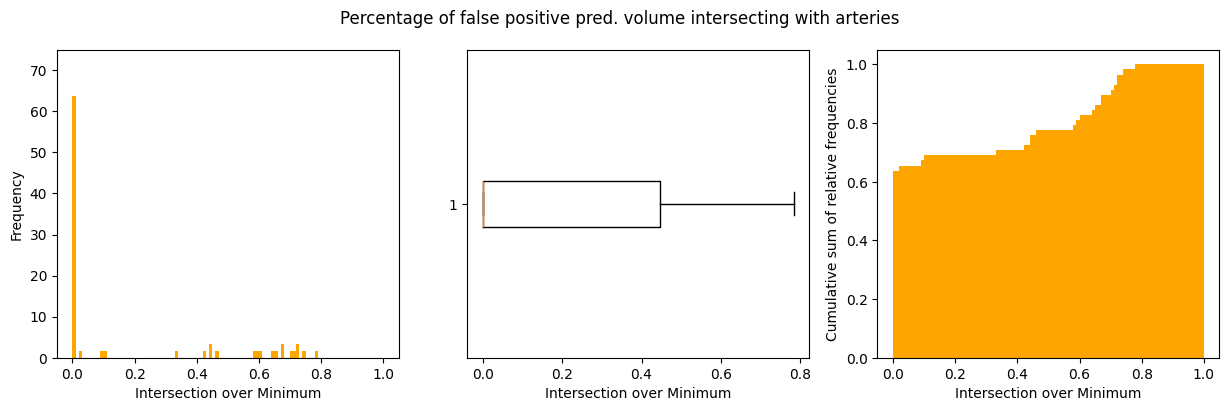

In [6]:
fig = visualize_iom(preds_fp, "arteries")

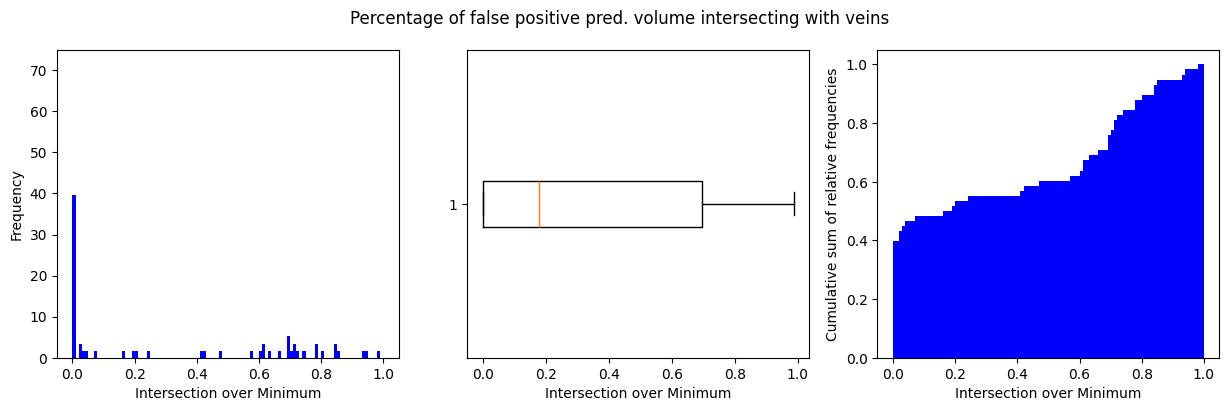

In [7]:
fig = visualize_iom(preds_fp, "veins")

In [8]:
print(
    "Number of False Positives intersecting with veins: ",
    len(preds_fp[preds_fp["vein_iom"] > 0.05]),
)
print(
    "Number of False Positives intersecting with arteries: ",
    len(preds_fp[preds_fp["artery_iom"] > 0.05]),
)

print(
    "Number of False Positives not intersecting with either: ",
    len(preds_fp[(preds_fp["vein_iom"] <= 0.05) & (preds_fp["artery_iom"] <= 0.05)]),
)

Number of False Positives intersecting with veins:  31
Number of False Positives intersecting with arteries:  20
Number of False Positives not intersecting with either:  10


(-0.01, 1.0)

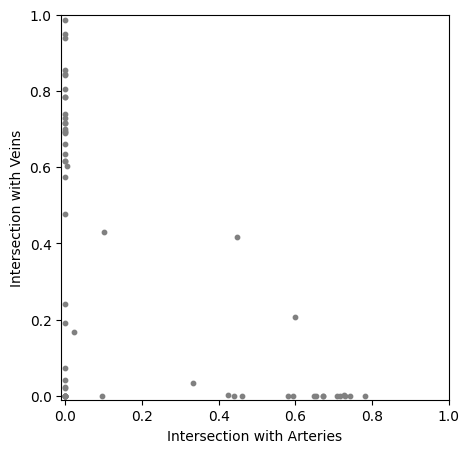

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.scatter(
    preds_fp["artery_iom"],
    preds_fp["vein_iom"],
    label="False positives",
    color="gray",
    s=10,
)
ax.set_xlabel("Intersection with Arteries")
ax.set_ylabel("Intersection with Veins")
ax.set_xlim(-0.01, 1)
ax.set_ylim(-0.01, 1)

In [16]:
preds_fp.sort_values("artery_iom", ascending=False).head(10)

,Unnamed: 0,seriesuid,probability,coordZ,coordY,coordX,d,h,w,artery_iom,vein_iom,threshold,is_fp
584,584,CA_00029_0000.nii.gz,0.653040,1.048550,318.06442,187.92355,11.919010,13.486878,13.909169,0.881944,0.000000,0,1
546,546,CA_00027_0000.nii.gz,0.632220,119.535450,353.58560,331.88818,11.315964,13.417658,13.660994,0.860417,0.009722,14,1
661,661,CA_00033_0000.nii.gz,0.853819,62.229713,370.01904,262.61180,15.652503,17.659409,17.777699,0.782924,0.000279,6,1
602,602,CA_00030_0000.nii.gz,0.994970,532.584500,385.07062,350.33127,11.743098,15.231483,15.140327,0.743367,0.000000,376,1
442,442,CA_00022_0000.nii.gz,0.755914,61.895287,300.13855,244.77022,15.337570,17.369173,17.151060,0.729911,0.000000,49,1


In [17]:
preds_fp.sort_values("artery_iom", ascending=True).head(10)

,Unnamed: 0,seriesuid,probability,coordZ,coordY,coordX,d,h,w,artery_iom,vein_iom,threshold,is_fp
1,1,CA_00000_0000.nii.gz,0.802524,141.22119,154.04185,162.35042,10.404429,13.143928,13.301341,0.0,0.949306,14,1
360,360,CA_00018_0000.nii.gz,0.999069,227.18788,207.95613,297.10416,16.529112,17.803950,17.814627,0.0,0.715088,26,1
362,362,CA_00018_0000.nii.gz,0.991133,157.23941,126.36064,298.02255,10.021105,12.402798,12.530825,0.0,0.986806,26,1
461,461,CA_00023_0000.nii.gz,0.818110,167.81921,337.09598,353.11752,15.096982,16.585262,16.296206,0.0,0.938058,45,1
745,745,CA_00037_0000.nii.gz,0.805847,476.07733,154.94266,301.19315,14.304571,17.296684,16.844890,0.0,0.805525,391,1
483,483,CA_00024_0000.nii.gz,0.732307,164.24045,264.65973,238.38281,9.250711,10.646990,11.148000,0.0,0.843750,53,1
521,521,CA_00026_0000.nii.gz,0.868614,261.72168,183.87798,187.56761,10.999478,14.698116,14.521962,0.0,0.000000,96,1
522,522,CA_00026_0000.nii.gz,0.836486,283.98890,175.98721,255.02838,16.044418,21.752750,21.102377,0.0,0.617344,96,1
523,523,CA_00026_0000.nii.gz,0.774414,221.09915,153.05911,362.35843,10.390128,12.389789,12.645574,0.0,0.856250,96,1
542,542,CA_00027_0000.nii.gz,0.867372,70.88745,295.90840,143.25050,11.680793,14.492582,14.365278,0.0,0.000000,14,1


In [19]:
preds_fp.sort_values("vein_iom", ascending=False).head(10)

,Unnamed: 0,seriesuid,probability,coordZ,coordY,coordX,d,h,w,artery_iom,vein_iom,threshold,is_fp
362,362,CA_00018_0000.nii.gz,0.991133,157.23941,126.36064,298.02255,10.021105,12.402798,12.530825,0.0,0.986806,26,1
1,1,CA_00000_0000.nii.gz,0.802524,141.22119,154.04185,162.35042,10.404429,13.143928,13.301341,0.0,0.949306,14,1
461,461,CA_00023_0000.nii.gz,0.818110,167.81921,337.09598,353.11752,15.096982,16.585262,16.296206,0.0,0.938058,45,1
523,523,CA_00026_0000.nii.gz,0.774414,221.09915,153.05911,362.35843,10.390128,12.389789,12.645574,0.0,0.856250,96,1
483,483,CA_00024_0000.nii.gz,0.732307,164.24045,264.65973,238.38281,9.250711,10.646990,11.148000,0.0,0.843750,53,1
744,744,CA_00037_0000.nii.gz,0.873257,759.99710,163.72305,258.48984,20.589828,22.154380,21.998125,0.0,0.842500,391,1
161,161,CA_00008_0000.nii.gz,0.657117,380.04940,232.20056,266.95260,13.563603,16.477770,16.275640,0.0,0.830078,16,1
183,183,CA_00009_0000.nii.gz,0.606272,207.41693,206.73485,261.12793,11.622664,15.689124,15.458396,0.0,0.807653,20,1
745,745,CA_00037_0000.nii.gz,0.805847,476.07733,154.94266,301.19315,14.304571,17.296684,16.844890,0.0,0.805525,391,1
603,603,CA_00030_0000.nii.gz,0.991804,431.34940,440.29996,409.89800,11.478044,13.259679,13.380428,0.0,0.784722,376,1


# GT distance analysis


In [10]:
df_labels_tp = df_labels[df_labels["detected"] == 1]
df_labels_fn = df_labels[df_labels["detected"] == 0]

In [16]:
len(df_labels_tp)

48

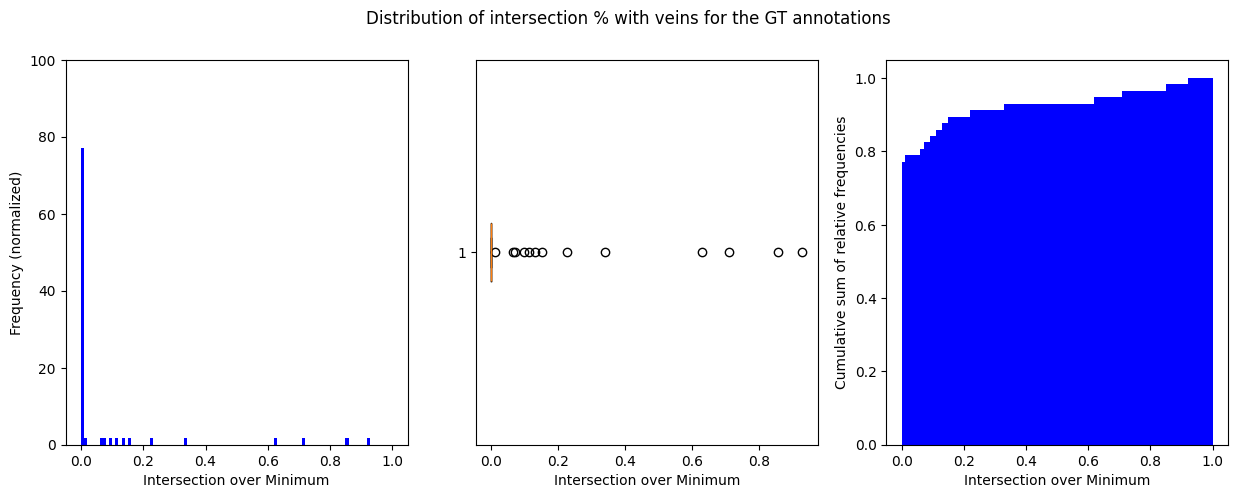

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
ax[0].hist(
    df_labels["iom_vein"],
    bins=100,
    range=(0, 1),
    label="False positives",
    density=True,
    color="blue",
)


plt.suptitle("Distribution of intersection % with veins for the GT annotations")
# paint the boxplot horizontally
ax[1].boxplot(
    df_labels["iom_vein"],
    vert=False,
)
# paint the cumsum of fequencyes
ax[2].hist(
    df_labels["iom_vein"],
    bins=100,
    range=(0, 1),
    cumulative=True,
    density=True,
    label="False positives",
    color="blue",
)
ax[0].set_ylim(0, 100)
ax[0].set_ylabel("Frequency (normalized)")
ax[0].set_xlabel("Intersection over Minimum")
ax[1].set_xlabel("Intersection over Minimum")
ax[2].set_xlabel("Intersection over Minimum")
ax[2].set_ylabel("Cumulative sum of relative frequencies")
plt.show()

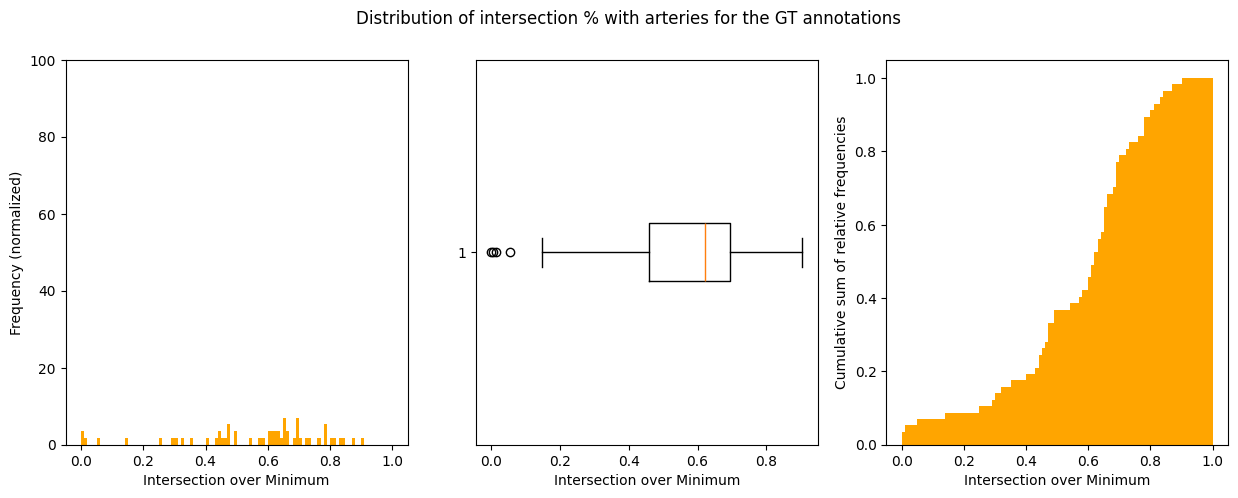

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
ax[0].hist(
    df_labels["iom_artery"],
    bins=100,
    range=(0, 1),
    density=True,
    color="orange",
)


plt.suptitle("Distribution of intersection % with arteries for the GT annotations")
# paint the boxplot horizontally
ax[1].boxplot(
    df_labels["iom_artery"],
    vert=False,
)
# paint the cumsum of fequencyes
ax[2].hist(
    df_labels["iom_artery"],
    bins=100,
    range=(0, 1),
    cumulative=True,
    density=True,
    color="orange",
)
ax[0].set_ylim(0, 100)
ax[0].set_ylabel("Frequency (normalized)")
ax[0].set_xlabel("Intersection over Minimum")
ax[1].set_xlabel("Intersection over Minimum")
ax[2].set_xlabel("Intersection over Minimum")
ax[2].set_ylabel("Cumulative sum of relative frequencies")
plt.show()

# Stats


In [53]:
vols, total_gt, "TP", total_correct / total_gt, "FP", total_fp / vols, "Aneurysms", total_gt, f"{int(np.sum(fn_per_case))}/{total_gt}"

(38,
 58,
 'TP',
 0.896551724137931,
 'FP',
 11.81578947368421,
 'Aneurysms',
 58,
 '6/58')

In [17]:
len([fp for fp in fp_per_case if fp == 0])

90

In [49]:
scans_with_fps_sick = []
scans_with_fps_healthy = []
scans_with_fns = []
for i in range(len(fp_per_case)):
    if fp_per_case[i] > 2 and gt_per_case[i] > 0:
        print("Case", case_names[i], "Healthy" if gt_per_case[i] == 0 else "Sick")
        print("GT", int(gt_per_case[i]))
        print("TP", int(correct_per_case[i]))
        print("FP", int(fp_per_case[i]))
        print("FN", int(fn_per_case[i]))
        print("\n")
        if fp_per_case[i] > 0:
            if gt_per_case[i] == 0:
                scans_with_fps_healthy.append(case_names[i])
            else:
                scans_with_fps_sick.append(case_names[i])

        if fn_per_case[i] > 0:
            scans_with_fns.append(case_names[i])

Case Ts0011.nii.gz Sick
GT 1
TP 0
FP 5
FN 1


Case Ts0052.nii.gz Sick
GT 1
TP 1
FP 4
FN 0


Case Ts0075.nii.gz Sick
GT 1
TP 1
FP 3
FN 0


Case Ts0084.nii.gz Sick
GT 1
TP 1
FP 4
FN 0


Case Ts0098.nii.gz Sick
GT 1
TP 1
FP 3
FN 0




In [45]:
scans_with_fns

['Ts0011.nii.gz',
 'Ts0061.nii.gz',
 'Ts0065.nii.gz',
 'Ts0111.nii.gz',
 'Ts0133.nii.gz',
 'Ts0136.nii.gz',
 'Ts0143.nii.gz']

In [42]:
for scan in scans_with_fps_sick:
    print(scan.replace(".nii.gz", ""))

print("----------")

for scan in scans_with_fps_healthy:
    print(scan.replace(".nii.gz", ""))

Ts0011
Ts0052
Ts0075
Ts0084
Ts0098
----------
Ts0110


In [11]:
df_labels.to_csv("predictions_internal_best_model.csv", index=False)

In [12]:
total_correct

116.0

In [13]:
# get accuracy per size
df_labels.groupby("size")["detected"].mean()

size
large     0.857143
medium    0.955556
small     0.827586
Name: detected, dtype: float64

In [14]:
path_sacc = "/home/ceballosarroyo.a/workspace/medical/cta-det2/labels/external_0.4_crop_reviewed.csv"
df_sacc = pd.read_csv(path_sacc)
df_labels["type"] = df_sacc["type"]
df_labels["comments"] = df_sacc["comments"].fillna("No_comment")
# get accuracy per type
df_labels.groupby("type")["detected"].mean()

type
fusiform    0.750000
saccular    0.948454
Name: detected, dtype: float64

In [15]:
df_labels["partition"].value_counts()

partition
Int    126
Name: count, dtype: int64

In [16]:
df_labels["type"].value_counts()

type
saccular    97
fusiform     4
Name: count, dtype: int64

In [17]:
df_labels.groupby("comments")["detected"].mean()

comments
M4                                                                          1.000000
No_comment                                                                  0.936170
P1/P2 junction                                                              1.000000
P4                                                                          1.000000
Pcomm                                                                       0.875000
Pcomm, multilobulated                                                       1.000000
broad-based                                                                 0.857143
label should be smaller (it includes some of the adjacent normal vessel)    1.000000
multilobulated                                                              0.966667
proximal M1                                                                 1.000000
superior hypophyseal                                                        1.000000
Name: detected, dtype: float64

In [19]:
df_labels.head()

,seriesuid,coordX,coordY,coordZ,w,h,d,lesion,volume,min_axis,maj_axis,volume_mm,diameter,size,partition,detected,type,comments
0,Ts0006.nii.gz,299.5,240.5,119.0,3.2,4.0,2.8,aneurysm,263.0,6.372496,11.023874,16.832,2.297296,small,Int,1,saccular,multilobulated
1,Ts0007.nii.gz,399.5,335.5,1007.0,4.0,4.8,4.4,aneurysm,800.0,11.103320,12.624308,51.200,3.328600,medium,Int,1,saccular,No_comment
2,Ts0008.nii.gz,218.5,241.5,558.5,6.4,8.0,4.8,aneurysm,1603.0,11.482374,21.293568,102.592,4.196393,medium,Int,1,saccular,Pcomm
3,Ts0009.nii.gz,435.5,260.0,946.5,9.6,10.0,6.4,aneurysm,4057.0,14.124872,28.024761,259.648,5.718735,medium,Int,1,saccular,No_comment
4,Ts0010.nii.gz,249.0,239.0,139.0,10.8,11.6,10.0,aneurysm,7494.0,22.409003,29.244622,479.616,7.016753,large,Int,1,saccular,No_comment


(14, 50)

In [21]:
sick_case_indics = np.where(np.array(gt_per_case) > 0)[0]
sick_fn = np.array(fn_per_case)[sick_case_indics]
len(sick_case_indics) - sum(sick_fn > 0), len(sick_case_indics)

(92, 102)

In [49]:
total_correct / 126

0.5714285714285714

In [ ]:
Teh query  torch.Size([32, 8, 384])
Teh values torch.Size([512, 24, 8, 128])

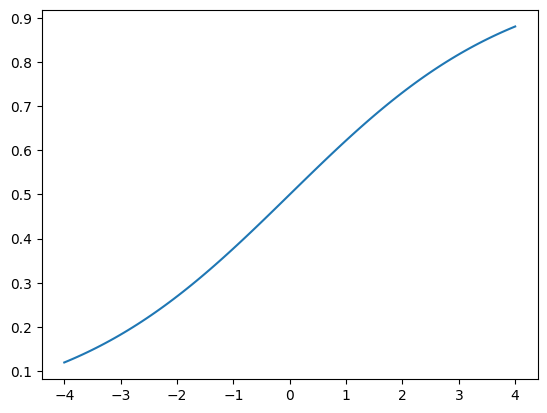

In [8]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt


def softer_sigmoid(x, beta=1):
    return 1 / (1 + np.exp(-beta * x))


# plot

x = np.linspace(-4, 4, 100)
y = softer_sigmoid(x, beta=0.5)
plt.plot(x, y)

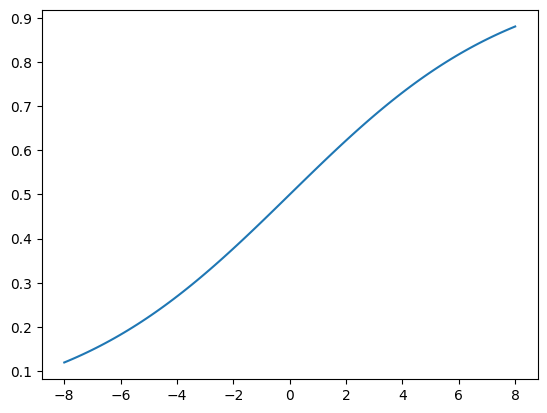

In [9]:
x = np.linspace(-8, 8, 100)
y = softer_sigmoid(x, beta=0.25)
plt.plot(x, y)